In [3]:
# Import relevant functionality

from langchain.chat_models import init_chat_model
from langchain_tavily import TavilySearch
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent
from dotenv import load_dotenv
load_dotenv()
# Создаём память
memory = MemorySaver()

# Инициализируем OpenAI-модель
llm = init_chat_model("gpt-4.1-mini", model_provider="openai")
# llm = init_chat_model("gpt-4.1", model_provider="openai")
# llm = init_chat_model("o3-mini", model_provider="openai")  # можно и так

# Подключаем инструмент поиска
search = TavilySearch(max_results=2)
tools = [search]

# Создаём агента
agent_executor = create_react_agent(llm, tools, checkpointer=memory)

In [4]:
# Use the agent
config = {"configurable": {"thread_id": "abc123"}}

input_message = {
    "role": "user",
    "content": "Hi, I'm Bob and I live in SF.",
}
for step in agent_executor.stream(
        {"messages": [input_message]}, config, stream_mode="values"
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, I'm Bob and I live in SF.
================================== Ai Message ==================================

Hi Bob! It's great to meet you. How can I assist you today in San Francisco?


In [5]:
input_message = {
    "role": "user",
    "content": "What's the weather where I live?",
}

for step in agent_executor.stream(
        {"messages": [input_message]}, config, stream_mode="values"
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What's the weather where I live?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_lQHQBaOob2XiDuvZqNsiQ6U9)
 Call ID: call_lQHQBaOob2XiDuvZqNsiQ6U9
  Args:
    query: weather forecast San Francisco
================================= Tool Message =================================
Name: tavily_search

{"query": "weather forecast San Francisco", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Weather in San Francisco", "url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'San Francisco', 'region': 'California', 'country': 'United States of America', 'lat': 37.775, 'lon': -122.4183, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1755777678, 'localtime': '2025-08-21 05:01'}, 'current': {'last_updated_epoch': 1755777600, 'last_updated': '2025-08-21 05:00', 'temp_c': 14.4, 'temp_f': 57.9, 'is

In [7]:
import getpass
import os

# os.environ["LANGSMITH_TRACING"] = "true"
# os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

In [8]:
from langchain_tavily import TavilySearch

search = TavilySearch(max_results=2)
search_results = search.invoke("What is the weather in SF")
print(search_results)
# If we want, we can create other tools.
# Once we have all the tools we want, we can put them in a list that we will reference later.
tools = [search]

{'query': 'What is the weather in SF', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': 'Weather in San Francisco, CA', 'url': 'https://www.weatherapi.com/', 'content': "{'location': {'name': 'San Francisco', 'region': 'California', 'country': 'United States of America', 'lat': 37.775, 'lon': -122.4183, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1755776536, 'localtime': '2025-08-21 04:42'}, 'current': {'last_updated_epoch': 1755775800, 'last_updated': '2025-08-21 04:30', 'temp_c': 14.4, 'temp_f': 57.9, 'is_day': 0, 'condition': {'text': 'Fog', 'icon': '//cdn.weatherapi.com/weather/64x64/night/248.png', 'code': 1135}, 'wind_mph': 4.9, 'wind_kph': 7.9, 'wind_degree': 223, 'wind_dir': 'SW', 'pressure_mb': 1014.0, 'pressure_in': 29.94, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 97, 'cloud': 25, 'feelslike_c': 14.2, 'feelslike_f': 57.5, 'windchill_c': 12.4, 'windchill_f': 54.3, 'heatindex_c': 12.9, 'heatindex_f': 55.2, 'dewpoint_c': 12.4, 'dewpoi

In [11]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools)

In [12]:
input_message = {"role": "user", "content": "Hi!"}
response = agent_executor.invoke({"messages": [input_message]})

for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi!
================================== Ai Message ==================================

Hello! How can I assist you today?


In [13]:
config = {"configurable": {"thread_id": "xyz123"}}

input_message = {"role": "user", "content": "What's my name?"}
for step in agent_executor.stream(
        {"messages": [input_message]}, config, stream_mode="values"
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What's my name?
================================== Ai Message ==================================

I don't have access to personal data about you unless you share it with me during our conversation. So, I don't know your name. If you'd like to tell me your name, feel free!


In [14]:
# %pip install -U --quiet langgraph langchain-openai langchain-tavily tiktoken

Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.


In [15]:
import json
from typing import List, Literal, Optional

import tiktoken
from langchain_core.documents import Document
from langchain_core.embeddings import Embeddings
from langchain_core.messages import get_buffer_string
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_tavily import TavilySearch
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode

In [16]:
recall_vector_store = InMemoryVectorStore(OpenAIEmbeddings())

In [17]:
import uuid


def get_user_id(config: RunnableConfig) -> str:
    user_id = config["configurable"].get("user_id")
    if user_id is None:
        raise ValueError("User ID needs to be provided to save a memory.")

    return user_id


@tool
def save_recall_memory(memory: str, config: RunnableConfig) -> str:
    """Save memory to vectorstore for later semantic retrieval."""
    user_id = get_user_id(config)
    document = Document(
        page_content=memory, id=str(uuid.uuid4()), metadata={"user_id": user_id}
    )
    recall_vector_store.add_documents([document])
    return memory


@tool
def search_recall_memories(query: str, config: RunnableConfig) -> List[str]:
    """Search for relevant memories."""
    user_id = get_user_id(config)

    def _filter_function(doc: Document) -> bool:
        return doc.metadata.get("user_id") == user_id

    documents = recall_vector_store.similarity_search(
        query, k=3, filter=_filter_function
    )
    return [document.page_content for document in documents]

In [18]:
search = TavilySearch(max_results=1)
tools = [save_recall_memory, search_recall_memories, search]

In [19]:
class State(MessagesState):
    # add memories that will be retrieved based on the conversation context
    recall_memories: List[str]

In [20]:
# Define the prompt template for the agent
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant with advanced long-term memory"
            " capabilities. Powered by a stateless LLM, you must rely on"
            " external memory to store information between conversations."
            " Utilize the available memory tools to store and retrieve"
            " important details that will help you better attend to the user's"
            " needs and understand their context.\n\n"
            "Memory Usage Guidelines:\n"
            "1. Actively use memory tools (save_core_memory, save_recall_memory)"
            " to build a comprehensive understanding of the user.\n"
            "2. Make informed suppositions and extrapolations based on stored"
            " memories.\n"
            "3. Regularly reflect on past interactions to identify patterns and"
            " preferences.\n"
            "4. Update your mental model of the user with each new piece of"
            " information.\n"
            "5. Cross-reference new information with existing memories for"
            " consistency.\n"
            "6. Prioritize storing emotional context and personal values"
            " alongside facts.\n"
            "7. Use memory to anticipate needs and tailor responses to the"
            " user's style.\n"
            "8. Recognize and acknowledge changes in the user's situation or"
            " perspectives over time.\n"
            "9. Leverage memories to provide personalized examples and"
            " analogies.\n"
            "10. Recall past challenges or successes to inform current"
            " problem-solving.\n\n"
            "## Recall Memories\n"
            "Recall memories are contextually retrieved based on the current"
            " conversation:\n{recall_memories}\n\n"
            "## Instructions\n"
            "Engage with the user naturally, as a trusted colleague or friend."
            " There's no need to explicitly mention your memory capabilities."
            " Instead, seamlessly incorporate your understanding of the user"
            " into your responses. Be attentive to subtle cues and underlying"
            " emotions. Adapt your communication style to match the user's"
            " preferences and current emotional state. Use tools to persist"
            " information you want to retain in the next conversation. If you"
            " do call tools, all text preceding the tool call is an internal"
            " message. Respond AFTER calling the tool, once you have"
            " confirmation that the tool completed successfully.\n\n",
        ),
        ("placeholder", "{messages}"),
    ]
)

In [21]:
model = ChatOpenAI(model_name="gpt-4o")
model_with_tools = model.bind_tools(tools)

tokenizer = tiktoken.encoding_for_model("gpt-4o")


def agent(state: State) -> State:
    """Process the current state and generate a response using the LLM.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        schemas.State: The updated state with the agent's response.
    """
    bound = prompt | model_with_tools
    recall_str = (
            "<recall_memory>\n" + "\n".join(state["recall_memories"]) + "\n</recall_memory>"
    )
    prediction = bound.invoke(
        {
            "messages": state["messages"],
            "recall_memories": recall_str,
        }
    )
    return {
        "messages": [prediction],
    }


def load_memories(state: State, config: RunnableConfig) -> State:
    """Load memories for the current conversation.

    Args:
        state (schemas.State): The current state of the conversation.
        config (RunnableConfig): The runtime configuration for the agent.

    Returns:
        State: The updated state with loaded memories.
    """
    convo_str = get_buffer_string(state["messages"])
    convo_str = tokenizer.decode(tokenizer.encode(convo_str)[:2048])
    recall_memories = search_recall_memories.invoke(convo_str, config)
    return {
        "recall_memories": recall_memories,
    }


def route_tools(state: State):
    """Determine whether to use tools or end the conversation based on the last message.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        Literal["tools", "__end__"]: The next step in the graph.
    """
    msg = state["messages"][-1]
    if msg.tool_calls:
        return "tools"

    return END

In [23]:
# Create the graph and add nodes
builder = StateGraph(State)
builder.add_node(load_memories)
builder.add_node(agent)
builder.add_node("tools", ToolNode(tools))

# Add edges to the graph
builder.add_edge(START, "load_memories")
builder.add_edge("load_memories", "agent")
builder.add_conditional_edges("agent", route_tools, ["tools", END])
builder.add_edge("tools", "agent")

# Compile the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

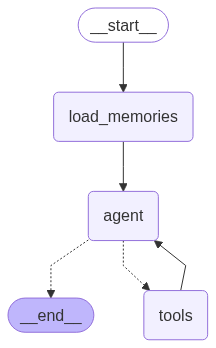

In [24]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
def pretty_print_stream_chunk(chunk):
    for node, updates in chunk.items():
        print(f"Update from node: {node}")
        if "messages" in updates:
            updates["messages"][-1].pretty_print()
        else:
            print(updates)

        print("\n")

In [26]:
# NOTE: we're specifying `user_id` to save memories for a given user
config = {"configurable": {"user_id": "1", "thread_id": "1"}}

for chunk in graph.stream({"messages": [("user", "my name is John")]}, config=config):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': []}


Update from node: agent
================================== Ai Message ==================================

Nice to meet you, John! How can I assist you today?




In [27]:
for chunk in graph.stream({"messages": [("user", "i love pizza")]}, config=config):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': []}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (call_McFHcPVSv2A6sdTgNjfBwH6A)
 Call ID: call_McFHcPVSv2A6sdTgNjfBwH6A
  Args:
    memory: John loves pizza.


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

John loves pizza.


Update from node: agent
================================== Ai Message ==================================

Pizza is great! Do you have a favorite type or topping?




In [28]:
for chunk in graph.stream(
        {"messages": [("user", "yes -- pepperoni!")]},
        config={"configurable": {"user_id": "1", "thread_id": "1"}},
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ['John loves pizza.']}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (call_wb5QQz0xu05kAjQKmSSrLBZa)
 Call ID: call_wb5QQz0xu05kAjQKmSSrLBZa
  Args:
    memory: John's favorite pizza topping is pepperoni.


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

John's favorite pizza topping is pepperoni.


Update from node: agent
================================== Ai Message ==================================

Pepperoni is a classic favorite! It's hard to beat that spicy and savory combination. Do you have a favorite place to get pizza from?




In [29]:
for chunk in graph.stream(
        {"messages": [("user", "i also just moved to new york")]},
        config={"configurable": {"user_id": "1", "thread_id": "1"}},
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ['John loves pizza.', "John's favorite pizza topping is pepperoni."]}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (call_OBITeCgorNmXg2uPz4tmjOTP)
 Call ID: call_OBITeCgorNmXg2uPz4tmjOTP
  Args:
    memory: John recently moved to New York.


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

John recently moved to New York.


Update from node: agent
================================== Ai Message ==================================

That's exciting! New York is famous for its pizza, so you're in a great place to explore different pizzerias. Have you had a chance to try any local spots yet?




In [30]:
config = {"configurable": {"user_id": "1", "thread_id": "2"}}

for chunk in graph.stream(
        {"messages": [("user", "where should i go for dinner?")]}, config=config
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ['John loves pizza.', 'John recently moved to New York.', "John's favorite pizza topping is pepperoni."]}


Update from node: agent
================================== Ai Message ==================================

Considering you recently moved to New York and love pizza, you might want to explore some of the renowned pizza spots there. You could try places like Di Fara Pizza in Brooklyn or Lombardi's Pizza in Manhattan, which are known for their classic New York-style pizzas. If you're in the mood for something else, let me know your preferences, and I can suggest other types of cuisine or dining experiences!




In [31]:
for chunk in graph.stream(
        {"messages": [("user", "what's the address for joe's in greenwich village?")]},
        config=config,
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ['John loves pizza.', 'John recently moved to New York.', "John's favorite pizza topping is pepperoni."]}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_zfULpnN4Javdobn88ds9ZSQ3)
 Call ID: call_zfULpnN4Javdobn88ds9ZSQ3
  Args:
    query: Joe's Pizza Greenwich Village address
    search_depth: basic


Update from node: tools
================================= Tool Message =================================
Name: tavily_search

{"query": "Joe's Pizza Greenwich Village address", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://en.wikipedia.org/wiki/Joe%27s_Pizza", "title": "Joe's Pizza", "content": "Joe's Pizza, also called Famous Joe's Pizza, is a pizzeria located in Greenwich Village, Manhattan, New York City on Carmine Street near Bleecker Street. In addition to its original location in Greenwich Village, 

In [32]:
recall_vector_store = InMemoryVectorStore(OpenAIEmbeddings())

In [33]:
from typing_extensions import TypedDict


class KnowledgeTriple(TypedDict):
    subject: str
    predicate: str
    object_: str


@tool
def save_recall_memory(memories: List[KnowledgeTriple], config: RunnableConfig) -> str:
    """Save memory to vectorstore for later semantic retrieval."""
    user_id = get_user_id(config)
    for memory in memories:
        serialized = " ".join(memory.values())
        document = Document(
            serialized,
            id=str(uuid.uuid4()),
            metadata={
                "user_id": user_id,
                **memory,
            },
        )
        recall_vector_store.add_documents([document])
    return memories

In [34]:
tools = [save_recall_memory, search_recall_memories, search]
model_with_tools = model.bind_tools(tools)


# Create the graph and add nodes
builder = StateGraph(State)
builder.add_node(load_memories)
builder.add_node(agent)
builder.add_node("tools", ToolNode(tools))

# Add edges to the graph
builder.add_edge(START, "load_memories")
builder.add_edge("load_memories", "agent")
builder.add_conditional_edges("agent", route_tools, ["tools", END])
builder.add_edge("tools", "agent")

# Compile the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [35]:
config = {"configurable": {"user_id": "3", "thread_id": "1"}}

for chunk in graph.stream({"messages": [("user", "Hi, I'm Alice.")]}, config=config):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': []}


Update from node: agent
================================== Ai Message ==================================

Hello, Alice! How can I assist you today?




In [36]:
for chunk in graph.stream(
        {"messages": [("user", "My friend John likes Pizza.")]}, config=config
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': []}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (call_JvXWH3KTJzbYOOvuyDx7KxYl)
 Call ID: call_JvXWH3KTJzbYOOvuyDx7KxYl
  Args:
    memories: [{'subject': 'Alice', 'predicate': 'has a friend', 'object_': 'John'}, {'subject': 'John', 'predicate': 'likes', 'object_': 'Pizza'}]


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

[{"subject": "Alice", "predicate": "has a friend", "object_": "John"}, {"subject": "John", "predicate": "likes", "object_": "Pizza"}]


Update from node: agent
================================== Ai Message ==================================

That's great to know! If you're looking for any pizza recommendations or perhaps planning something special with John, feel free to let me know!




In [37]:
config = {"configurable": {"user_id": "3", "thread_id": "2"}}

for chunk in graph.stream(
        {"messages": [("user", "What food should I bring to John's party?")]}, config=config
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ['John likes Pizza', 'Alice has a friend John']}


Update from node: agent
================================== Ai Message ==================================

Since I remember that John likes pizza, bringing a pizza to his party would be a great idea! It's a classic party food that most people enjoy, and it aligns well with his preferences. If you're looking for other options, perhaps consider adding some appetizers or a dessert to complement the meal.




In [38]:
%pip install -U --quiet matplotlib networkx

Note: you may need to restart the kernel to use updated packages.


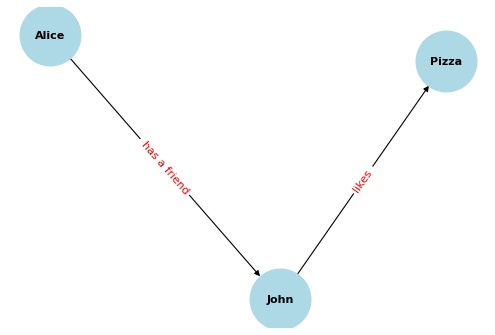

In [39]:
import matplotlib.pyplot as plt
import networkx as nx

# Fetch records
records = recall_vector_store.similarity_search(
    "Alice", k=2, filter=lambda doc: doc.metadata["user_id"] == "3"
)


# Plot graph
plt.figure(figsize=(6, 4), dpi=80)
G = nx.DiGraph()

for record in records:
    G.add_edge(
        record.metadata["subject"],
        record.metadata["object_"],
        label=record.metadata["predicate"],
    )

pos = nx.spring_layout(G)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=3000,
    node_color="lightblue",
    font_size=10,
    font_weight="bold",
    arrows=True,
)
edge_labels = nx.get_edge_attributes(G, "label")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")
plt.show()

посмотри документы, сделай саммари, позадавать вопросы;
1. читает страницу за страницей делает саммари, выводы с ссылками на страницу
2. парсим в RAG и задаем вопросы oss120b 